# Neural Network Implementation

In [1]:
#Methods related to forward propagation
import math
import numpy as np
import time

In [2]:
class Params:
    def __init__(self, W1, W2, b1, b2):
        ''' assumes 1 hidden layer, 1 output layer, where W1 is all weights from input to first hidden layer, 
        W2 is all weights from hidden layer to output layer.'''
        self.W1 = W1
        self.W2 = W2
        self.b1 = b1
        self.b2 = b2

def init_matrix(row, col):
    '''initialize from uniform distribution, divided by sqrt(col) for reasons I'm not sure of '''
    v= 1.0 /np.sqrt(col) # might not need to /sqrt() cuz related to assignment
    result = np.random.uniform(low=(-1*v), high=v, size=(row,col) )
    return result

def init_model(hidden_dim, input_dim, output_dim):
    '''initializes all the parameters of our model with dh hidden nodes'''
    W1 = init_matrix(hidden_dim, input_dim)
    W2 = init_matrix(output_dim, hidden_dim)
    b1 = np.zeros((1, hidden_dim))
    b2 = np.zeros((1, output_dim))
    p = Params(W1, W2, b1, b2)
    return p

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(a):
    """ Stable implementation on softmax function """
    a_max = np.max(a, axis=1)
    s = np.exp(a - np.tile(a_max, (a.shape[1],1)).T)
        
    # normalisation_factor
    n = np.sum(s, axis=1)
    n = 1.0/np.tile(n, (s.shape[1], 1))
    return np.multiply(s,n.T)

def output_act(w,x,b):
    '''output act func including preact func'''
#     print("x", np.shape(x))
#     print("w.T", np.shape(w.T))
#     print("b", np.shape(b))
    return softmax(np.dot(x, w.T) + b)

def hidden_pre(w,x,b):   
    '''hidden layer preact func'''
    return np.dot(x, w.T) + b

def hidden_act(ha):    
    '''hidden layer act func'''
    return sigmoid(ha)

def onehot(m, y):
    '''one hot encoding'''
    result = np.zeros(m)
    result[np.arange(m[0]), y.astype(int)] = 1
    return result

def L(os,y):
    '''loss func'''
#     print("os", np.shape(os))
#     print("y", np.shape(y))
    return np.sum(np.multiply(-1.0*np.log(os), onehot(os.shape,y)), axis=1)

def compute_fprop(w1,w2,b1,b2,x,y):
    ha = hidden_pre(w1,x,b1)
    hs = hidden_act(ha)
#     print(np.shape(hs))
    os = output_act(w2,hs,b2)
    l = L(os,y) 
    return os, ha, hs, l

def compute_predictions(fprop):
    return np.argmax(fprop[0], axis=1)

In [3]:
# Methods related to backpropagation
def rectPrime(v):
    """ derivative of RELU """
    return np.greater(v, np.zeros(v.shape)).astype(int)

def _grad_oa(os,y):
    """ grad_oa = grad_b2 gradient for output layer"""
    return os - onehot(os.shape,y)

def _grad_W(grad_a, hs):
    """ 
    For w2 use input :grad_oa and hs 
    for w1 use input : grad_ha and x
    Calculate new weights W'
    """
    # from http://stackoverflow.com/questions/16500426/is-there-a-more-vectorized-way-to-perform-numpy-outer-along-an-axis
    return grad_a[:,:,np.newaxis] * hs[:,np.newaxis,:]

def _grad_ha(ha,grad_hs):
    """ calculate new b1 """
    return np.multiply(rectPrime(ha), grad_hs)

def _grad_hs(grad_oa, W2):
    """ calculate new b2 """
    return np.dot(grad_oa, W2)

def grad_bprop(W1,W2,os,ha,hs,x,y):
    """calculate backpropagation"""
    grad_oa = _grad_oa(os,y) 
    grad_hs = _grad_hs(grad_oa, W2)
    grad_ha = _grad_ha(ha, grad_hs)
    par = Params(_grad_W(grad_ha,x), _grad_W(grad_oa,hs), grad_ha, grad_oa)
    return par  

def gradLot(params, data, data_y):
    """ Need to cross check with lecture notes """
#     print(data)
#     print("data_y", data_y)
    val_fprop = compute_fprop(params.W1, params.W2, params.b1, params.b2, data, data_y)
    new_params = grad_bprop(params.W1, params.W2, val_fprop[0],val_fprop[1],val_fprop[2],data, data_y)
    
    #print(val_fprop[0].shape, val_fprop[1].shape, val_fprop[2].shape, val_fprop[3].shape, data.shape, data_y.shape)
    #print(new_params.W1.shape, new_params.W2.shape, new_params.b1.shape, new_params.b2.shape)
    
    moy_W1 = np.mean(new_params.W1, axis=0)
    moy_W2 = np.mean(new_params.W2, axis=0)
    moy_b1 = np.mean(new_params.b1, axis=0)
    moy_b2 = np.mean(new_params.b2, axis=0)

    return Params(moy_W1, moy_W2, moy_b1, moy_b2)

## With Toy Kaggle Data

In [14]:
%matplotlib inline
import pandas as pd
from sklearn.cross_validation import train_test_split
n=100000

# Images (60x60)
X = np.fromfile('data/train_x.bin', count=-1, dtype='uint8')
X = X.reshape((n,60,60))
X = [np.reshape(x, (1,3600)) for x in X]

Y = pd.read_csv('data/train_y.csv', delimiter=',', index_col=0, engine='python').values[:n]

X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.10, random_state=0)

X_train = np.squeeze(X_train)
ens_train = np.concatenate((X_train, y_train), axis=1)
X_valid = np.squeeze(X_valid)
ens_valid = np.concatenate((X_valid, y_valid), axis=1)


# data_1 = np.reshape(train_X[0], (1,3600))
# data_2 = np.reshape(train_X[1], (1,3600))

# Recombine train and valid

# Labels
# train_y = pd.read_csv('data/train_y.csv', delimiter=',', index_col=0, engine='python').values[:n]

In [5]:
# # insert two examples of data into neural network for forward pass

# # CONFIG FOR NEURAL NETWORK
# input_dim = 3600 # we model 60 x 60 pixel img as 1 x 3600 arrays
# hidden_dim = 9
# output_dim = 19

# # MADE-UP WEIGHTS AND BIASES
# W1 = np.array([[1.0,2.0,3.0],[1.0,2.0,3.0],[1.0,2.0,3.0],[1.0,2.0,3.0]]) # hidden_dim x input_dim
# W1 = np.arange(1,input_dim+1)
# W1 = np.tile(W1, (hidden_dim,1))
# W2 = np.arange(1, hidden_dim +1) 
# W2 = np.tile(W2, (output_dim,1)) # num_class x hidden_dim
# b1 = np.array([2.0]*hidden_dim) # 1 x hidden
# b2 = np.array([1.0]*output_dim) # 1 x output

# # INSERT REAL DATA
# x = np.concatenate((data_1, data_2), axis=0) # 2 x 3600
# y = np.array([7,9]) 
# val = compute_fprop(W1,W2,b1,b2,x,y) 
# compute_predictions(val)
# grad = grad_bprop(W1,W2, val[0],val[1],val[2],x,y)



## Training a Model

In the neural network terminology:

**one epoch** = one forward pass and one backward pass of all the training examples

**batch size** = the number of training examples in one forward/backward pass. The higher the batch size, the more memory space you'll need.

**number of iterations** = number of passes, each pass using [batch size] number of examples. To be clear, one pass = one forward pass + one backward pass (we do not count the forward pass and backward pass as two different passes).

**Example:** if you have 1000 training examples, and your batch size is 500, then it will take 2 iterations to complete 1 epoch.

In [6]:
#Timing function
#Taken from stack overflow (URL lost)
def timeit(f):
    def wrap(*args):
        time1 = time.time()
        ret = f(*args)
        time2 = time.time()
#         print(f)
#         print(f.func_name)
        print('%s function took %0.3f ms' % (f.__name__, (time2-time1)*1000.0))
        return ret
    return wrap

In [9]:
#updates parameters of our models, and applies penalty
def update_params(p, moy, learning_rate, penalty_lambda):
    '''Need to understand .... '''
    penaltyW1 = learning_rate * 2 * p.W1 * penalty_lambda
    penaltyW2 = learning_rate * 2 * p.W2 * penalty_lambda
    p.W1 -= penaltyW1
    p.W2 -= penaltyW2
    p.W1 -= learning_rate * moy.W1
    p.W2 -= learning_rate * moy.W2
    p.b1 -= learning_rate * moy.b1
    p.b2 -= learning_rate * moy.b2
    return p

#Trains a model
@timeit
def train_model(p, ens_train, batch_size, learning_rate, penalty_lambda, num_epochs, num_feats, ens_valid, ens_test, calcTotalGrad, show_epoch_data,dataset):
    params_total = Params(np.zeros(p.W1.shape),np.zeros(p.W2.shape),np.zeros(p.b1.shape),np.zeros(p.b2.shape) ) 
    epoch_data = []

    for x in range(num_epochs):
        start_index = 0
        end_index = 0 
        n = len(ens_train)
#         print("n", n)
        while end_index < n:
            end_index = min(end_index+ batch_size, n) # end_index keeps moving to cover new/current batch
            train_data = ens_train[start_index: end_index, 0:num_feats]
            train_y_data = ens_train[start_index: end_index, -1] # labels are last index            
            start_index = end_index
            
            grad_moy = gradLot(p, train_data, train_y_data) # what is gradLot?
            if calcTotalGrad:
                params_total.W1 += grad_moy.W1
                params_total.W2 += grad_moy.W2
                params_total.b1 += grad_moy.b1
                params_total.b2 += grad_moy.b2
            p = update_params(p, grad_moy, learning_rate, penalty_lambda)
            
        if show_epoch_data:
            print("For Epoch", x+1)
            model = compute_fprop(p.W1,p.W2,p.b1,p.b2,ens_train[:,:-1],ens_train[:,-1])
            cout_train = np.sum(model[3])
            cout_train = 1.0*cout_train/ens_train.shape[0]
            print("Train Cost:", cout_train)
            error_train = calc_print_error_rate(model, ens_train, "Training")
    
            model = compute_fprop(p.W1,p.W2,p.b1,p.b2,ens_valid[:,:-1],ens_valid[:,-1])
            cout_valid = np.sum(model[3])
            cout_valid = 1.0*cout_valid/ens_valid.shape[0]
            print("Valid Cost:", cout_valid)
            error_valid = calc_print_error_rate(model, ens_valid, "Validation")
                
            model = compute_fprop(p.W1,p.W2,p.b1,p.b2,ens_test[:,:-1],ens_test[:,-1])
            cout_test = np.sum(model[3])
            cout_test = 1.0*cout_test/ens_test.shape[0]
            print("Test Cost:", cout_test)
            error_test = calc_print_error_rate(model, ens_test, "Test")
            epoch_data.append([cout_train, error_train, cout_valid, error_valid, cout_test, error_test])
            print("\n\n")
    if show_epoch_data:
        #write epoch data to file
        f = open('output_data','w')
        pickle.dump(np.array(epoch_data), f)
        f.close()

    if calcTotalGrad:
        print("Total Gradient:")
        print("W1:",  params_total.W1)   
        print("W2:",  params_total.W2)   
        print("b1:",  params_total.b1)   
        print("b2:",  params_total.b2)   
    return p

# Calculates error rate and prints
def calc_print_error_rate(model, ens_train, dataset_tag):
    classesPred = compute_predictions(model)
    error_rate = ((1-(classesPred==ens_train[:,-1]).mean())*100.0)
    print("Error Rate-", dataset_tag, " %.2f%%" % error_rate)
    return error_rate

#Function used to generate a model, train it, and show decision region/error rate

def init_train_plotModel(ens_train, ens_valid, ens_test, batch_size, learning_rate, penalty_lambda, hidden_nodes, error_msg_label, num_epochs, calcTotalGrad=False, show_epoch_data=False):
    np.random.seed(seed=123)
    
    num_feats = 3600 
    num_classes = 2
    
#     if dataset == "mnist":
#         num_feats = 784 
#         num_classes = 10
        
    model = init_model(hidden_nodes, num_feats, num_classes)
    model = train_model(model, ens_train, batch_size, learning_rate, penalty_lambda, num_epochs, num_feats, ens_valid, ens_test, calcTotalGrad,show_epoch_data,dataset)
    #now trained, model contains our learned parameters 

    #convert model into fprop type for calculations
    model = compute_fprop(model.W1,model.W2,model.b1,model.b2,ens_valid[:,0:num_feats],ens_valid[:,-1])

    print(error_msg_label)
    calc_print_error_rate(model, ens_valid, "Test")

In [ ]:
hidden_nodes = 20
num_feats = 3600
num_classes = 19
batch_size = 10
learning_rate = 0.5
penalty_lambda = 0.01
num_epochs = 10
calcTotalGrad=True
show_epoch_data=False
dataset=""
error_msg_label = "Error rate with batch size = " + str(batch_size)
# get previously init data

model = init_model(hidden_nodes, num_feats, num_classes)
model = train_model(model, ens_train, batch_size, learning_rate, penalty_lambda, num_epochs, num_feats, ens_valid, ens_test, calcTotalGrad, show_epoch_data,dataset)

#convert model into fprop type for calculations
model = compute_fprop(model.W1,model.W2,model.b1,model.b2,ens_valid[:,0:num_feats],ens_valid[:,-1])

print(error_msg_label)
calc_print_error_rate(model, ens_valid, "Test")

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:26: RuntimeWarning: overflow encountered in exp


In [15]:
print(np.shape(ens_valid))

(10000, 3601)


In [ ]:
# Hyperparameters
# Layers: [3.,] # gradually decrease the units per layer
# Hidden Units: [500, 1000, 2000]

# Refer: 
# hidden_nodes = 20
# batch_size = 1
# learning_rate = 0.5
# penalty_lambda = 0.001
# num_epochs = 1

--------

## Appendix

## Visualizing Data

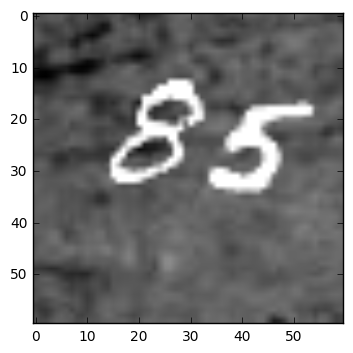

In [102]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(train_X[12000], plt.get_cmap('gray'))
data = train_X[0]
# need to create 60 * 60 * 3 = 10800 input neurons 

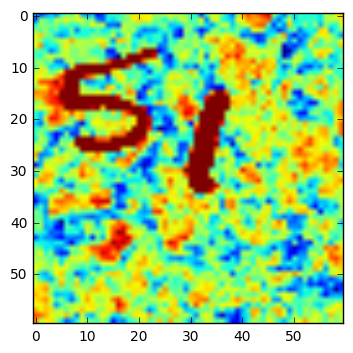

In [104]:
plt.imshow(train_X[-666], )

In [ ]:
plt.imshow(train_X[0])